# 아파트 경매가격 예측 경진대회
- <a href="https://dacon.io/competitions/official/17801/data/">대회 링크</a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import os
from scipy import stats

In [4]:
d = 'C:/kaggle_data/house_auction/'
os.listdir(d)

['Auction_master_en',
 'Auction_master_kr',
 'Auction_master_test.csv',
 'Auction_master_train.csv',
 'Auction_regist.csv',
 'Auction_rent.csv',
 'Auction_result.csv',
 'Auction_submission.csv']

# 파일 설명
1. Auction_master_train.csv – 서울/부산 지역의 낙찰가를 포함하여 경매 물건 아파트의 위치, 감정가, 경매 개시/종결일 등의 기본 정보(*최근2년)

2. Auction_master_test.csv – 경매 낙찰가를 제외하고 train.csv와 동일

3. Auction_submission.csv – 예측한 낙찰가를 기입하여 제출

4. Auctiuon_regist.csv – 아파트에 대한 등기 정보

5. Auctiuon_result.csv – 경매일자, 감정가, 최저매각가격, 경매 결과 데이터.

6. Auctiuon_rent.csv – 해당 아파트에 임차인이 있는 경우, 전입/점유 여부, 보증금, 월세 등의 데이터.

### auction_regist
*개별 경매: 1개의 사건 번호에 여러 물건으로 경매 진행될 경우


*과다등기: 등기명의인 수가 100인(말소등기포함)을 초과하는 경우


*개별 경매 중 다음과 같은 사항이 발생 시, 등기 정보가 누락될 수 있습니다.


a.모든 물건의 등기부등본이 동일한 경우(1개만 발급받은 경우)

b. 과다등기로 인한 등기부등본 발급이 어려운 경우 (예: 등기부등본에 채권자, 소유주 등 등재인이 너무 많아 등기부등본 발급이 안되는 경우)

In [5]:
train = pd.read_csv(d+'Auction_master_train.csv')
test = pd.read_csv(d+'Auction_master_test.csv')
ss = pd.read_csv(d+'Auction_submission.csv')

### 사실 아래 파일들은 안 씀
regist = pd.read_csv(d+'Auction_regist.csv')
rent = pd.read_csv(d+'Auction_rent.csv')
result = pd.read_csv(d+'Auction_result.csv')

# train 설명
- auction_key: 아파트 고유 키값
- auction_class
       1. 임의: 등기부등본 담보권(저당권, 가압류등)으로 경매
       2. 강제: 부동산에 대한 강제집행 방법의 하나로서 법원에서 채무자의 부동산을 압류·매각하여 그 대금으로 채권자의 금전채권의 만족에 충당시키는 절차
- Bid_class: 입찰 구분(일반/개별/일괄)
- Claim_price: 경매 신청인의 청구 금액
- Appraisal_company: 감정사
- Appraisal_date: 감정일
- Auction_count: 총경매횟수
- Auction_miscarriage_count: 총유찰횟수
- Total_land_gross_area: 총토지전체면적
- Total_land_real_area: 총토지실면적
- Total_land_auction_area: 총토지경매면적
- Total_building_area: 총건물면적
- Total_building_auction_area: 총건물경매면적
- Total_appraisal_price: 총감정가
- Minimum_sales_price: 최저매각가격, 입찰인이 최저로 제시해야 하는 금액
- First_auction_date: 최초경매일
- Final_auction_date: 최종경매일
- Final_result: 최종결과
- Creditor: 경매 신청인
- addr
    - do: 시도
    - si: 시군구
    - dong: 읍면동
    - li: 리
    - san: 산번지 여부
    - bunji1: 번지1
    - bunji2: 번지2
    - etc: 기타주소
- Apartment_usage: 건물(토지) 대표 용도
- Completion_date: 준공일
- Preserve_regist_date: 보존등기일, 신축하고 처음으로 등기한 일자
- Total_floor: 총층수
- Current_floor: 현재층수
- Specific: 기타 특이사항
- Share_auction_YorN: 지분경매여부(소유자가 전체가 아닌 지분을 소유하고 있는 경우)
- road
    - name: 도로명주소
    - bunji1: 번지1
    - bunji2: 번지2
- close_date: 종국일자
- close_result: 종국결과
- point.y : 위도
- point.x : 경도
- hammer_price: 낙찰가

# EDA
## Target값(Hammer price)

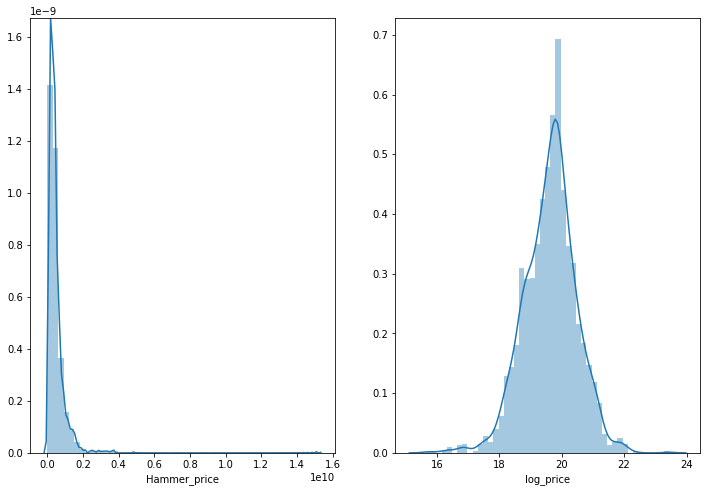

In [6]:
train['log_price'] = np.log1p(train['Hammer_price'])
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(12,8))
sns.distplot(train['Hammer_price'],ax=ax[0])
sns.distplot(train['log_price'],ax=ax[1])

## 중요해보이는 feature들
- Claim_price
- Total_land_auction_area
- Total_building_auction_area
- Minimum_sales_price: 최저매각가격, 입찰인이 최저로 제시해야 하는 금액
- Final_result
- addr...
- completion data

### Claim_price : 경매 신청인의 청구 금액
- claim_price도 로그변환 필요
- 변환했더니 이번엔 반대쪽으로 꼬리가 늘어짐
- 여기서 또 뭘 해야할 지는 모르겠는데..

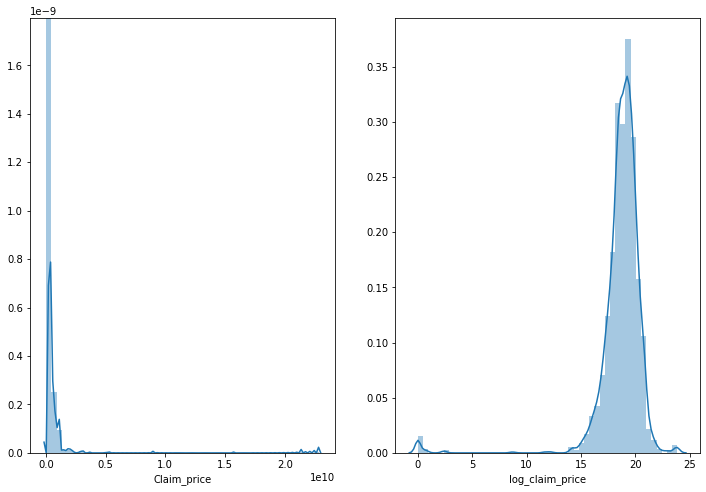

In [7]:
train['log_claim_price'] = np.log1p(train['Claim_price'])
test['log_claim_price'] = np.log1p(test['Claim_price'])
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(12,8))
sns.distplot(train['Claim_price'],ax=ax[0])
sns.distplot(train['log_claim_price'],ax=ax[1])

In [8]:
# 솔루션 보고 나서 추가한 내용
train['log_min'] = np.log(train['Minimum_sales_price'])

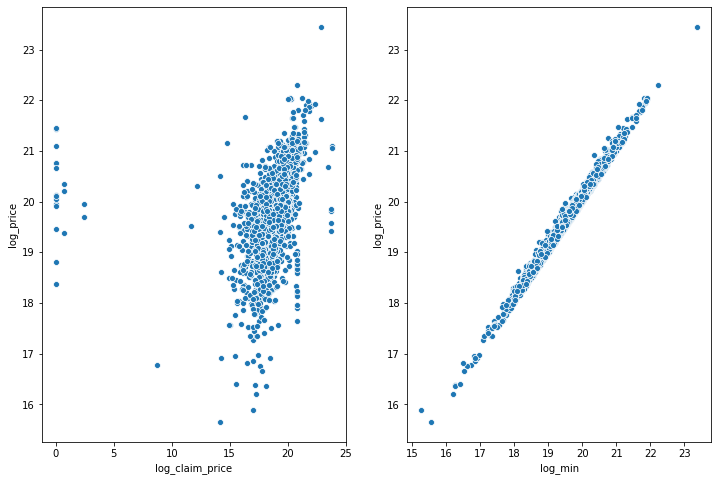

In [9]:
# 어느정도 선형성이 보인다. 왼쪽의 outlier들만 좀 처리해주면 좋을듯
f, ax = plt.subplots(nrows=1, ncols=2,figsize=(12,8))
sns.scatterplot(x='log_claim_price',y='log_price',data=train, ax=ax[0])
sns.scatterplot(x='log_min',y='log_price',data=train, ax=ax[1])

### auction_class와 bid_class를 hue로 주고 시각화

In [29]:
# 임의 0, 강제 1로 인코딩
train['Auction_class'] = (train['Auction_class']=='강제').astype('int')
test['Auction_class'] = (test['Auction_class']=='강제').astype('int')

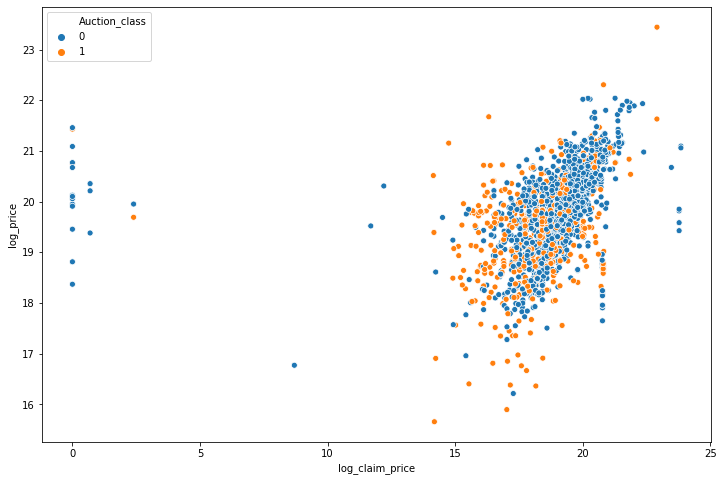

In [33]:
plt.figure(figsize=(12,8))
sns.scatterplot(x='log_claim_price',y='log_price',data=train, hue = 'Auction_class')

In [42]:
# 개별 0, 일반 1, 일괄 2
def enc(x):
    if x=='개별':
        x=0
    elif x=='일반':
        x=1
    elif x=='일괄':
        x=2
        
    return x

In [55]:
# 하나의 값에 대해 적용되는 함수를 시리즈 전체에 수행해주는 apply 
train['Bid_class'] = train['Bid_class'].apply(enc)
test['Bid_class'] = test['Bid_class'].apply(enc)

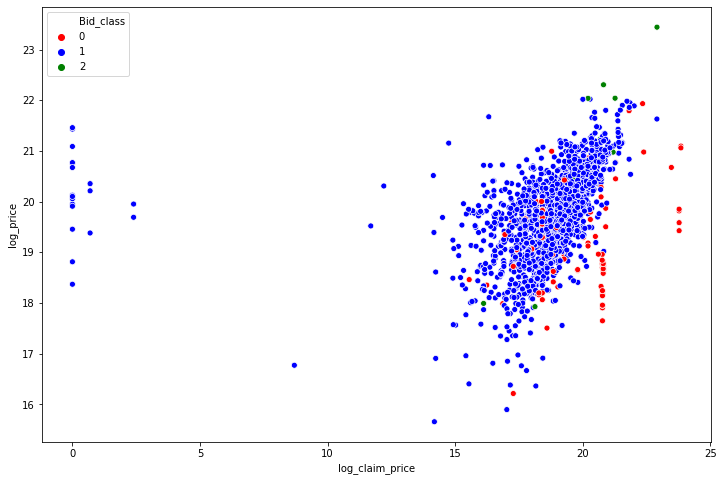

In [57]:
# 2는 1에다 붙여주자
plt.figure(figsize=(12,8))
sns.scatterplot(x='log_claim_price',y='log_price',data=train, hue = 'Bid_class',palette=['red','blue','green'])

In [61]:
train.loc[train['Bid_class'] == 2,'Bid_class'] = 1
test.loc[test['Bid_class'] == 2,'Bid_class'] = 1

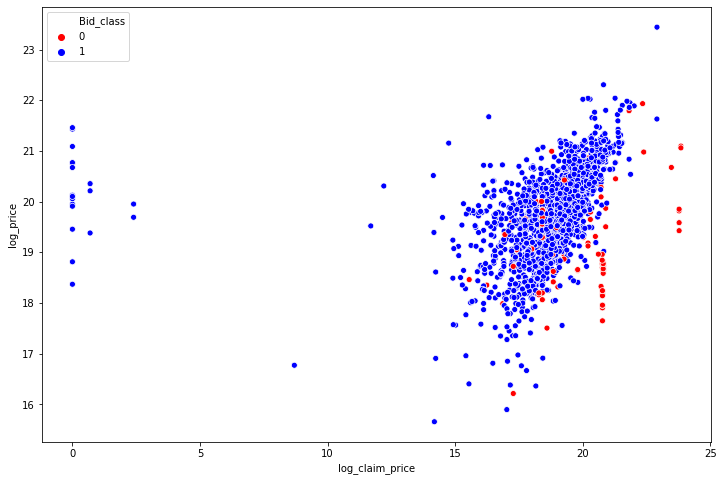

In [64]:
# 2는 1에다 붙여주자
plt.figure(figsize=(12,8))
sns.scatterplot(x='log_claim_price',y='log_price',data=train, hue = 'Bid_class',palette=['red','blue'])

## Total_land_auction_area
- 왠지 로그변환 해야될 것 처럼 생김

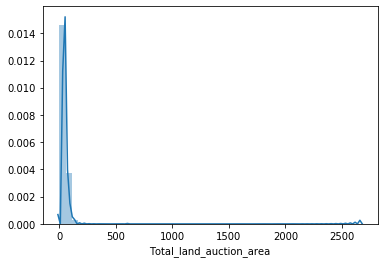

In [70]:
sns.distplot(train['Total_land_auction_area'])

In [71]:
train['log_land'] = np.log(train['Total_land_auction_area'])
test['log_land'] = np.log(test['Total_land_auction_area'])

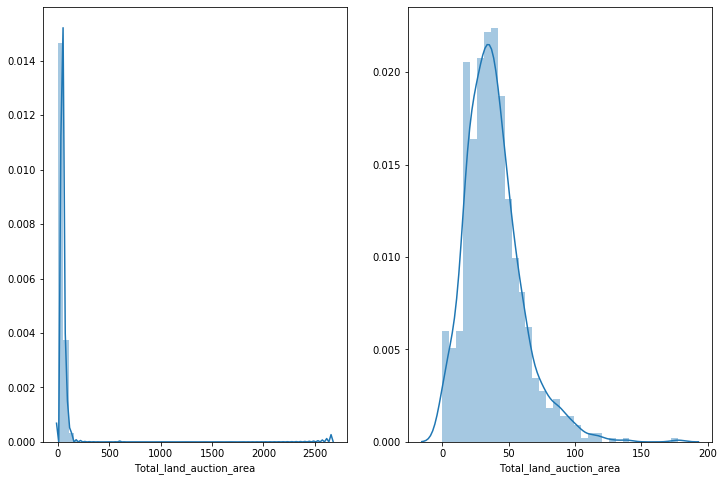

In [73]:
f, ax = plt.subplots(nrows=1, ncols=2,figsize=(12,8))
sns.distplot(train['Total_land_auction_area'],ax=ax[0])
sns.distplot(test['Total_land_auction_area'],ax=ax[1])

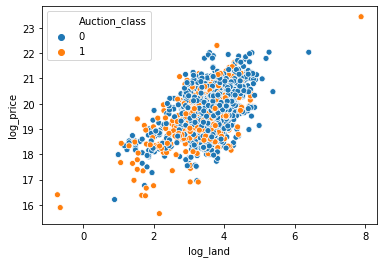

In [74]:
sns.scatterplot(x='log_land',y='log_price',hue='Auction_class',data=train)

### Total_building_auction_area

In [77]:
train['log_building'] = np.log(train['Total_building_auction_area'])
test['log_building'] = np.log(test['Total_building_auction_area'])

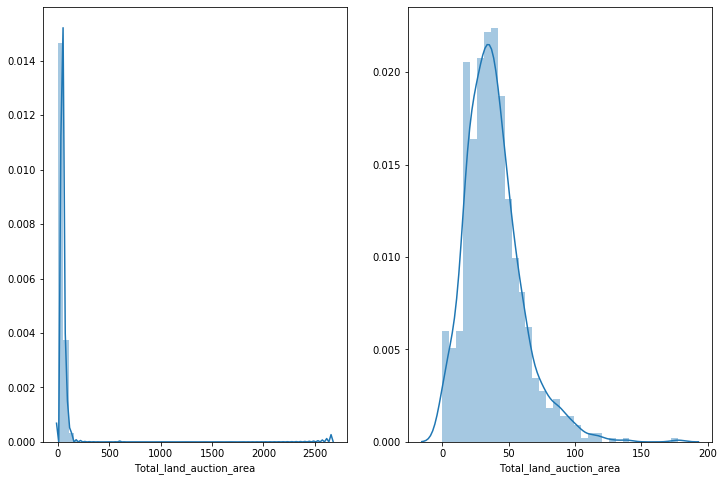

In [80]:
f, ax = plt.subplots(nrows=1, ncols=2,figsize=(12,8))
sns.distplot(train['Total_land_auction_area'],ax=ax[0])
sns.distplot(test['Total_land_auction_area'],ax=ax[1])

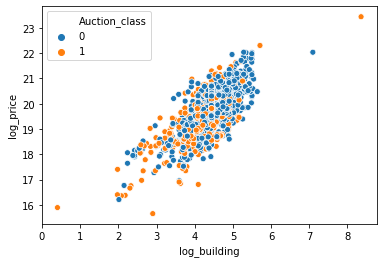

In [81]:
sns.scatterplot(x='log_building',y='log_price',hue='Auction_class',data=train)

#### land와 building의 상관관계

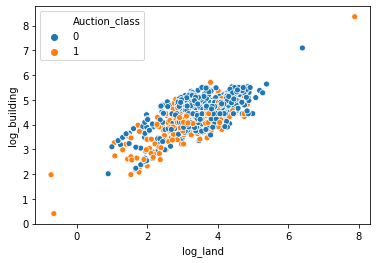

In [83]:
# 너무 상관관계가 있어서 안 될 것 같음
sns.scatterplot(x='log_land',y='log_building',data=train,hue='Auction_class')

### Minimum_sales_price: 최저매각가격, 입찰인이 최저로 제시해야 하는 금액
- 만만한 게 로그변환

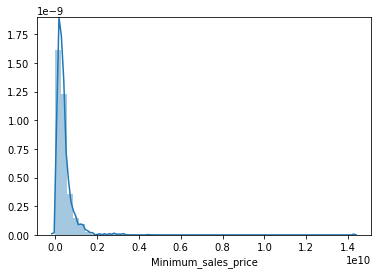

In [84]:
sns.distplot(train['Minimum_sales_price'])

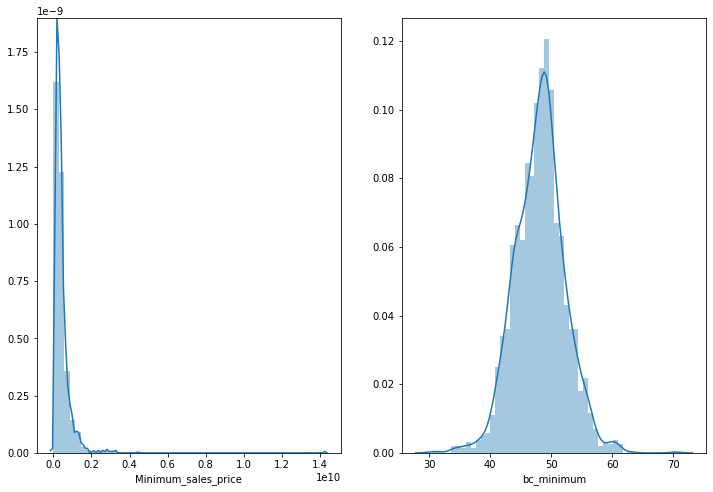

In [94]:
from scipy import stats
train['bc_minimum'] = stats.boxcox(train['Minimum_sales_price'])[0]
test['bc_minimum'] = stats.boxcox(test['Minimum_sales_price'])[0]
f, ax = plt.subplots(nrows=1, ncols=2,figsize=(12,8))
sns.distplot(train['Minimum_sales_price'],ax=ax[0])
sns.distplot(train['bc_minimum'],ax=ax[1])

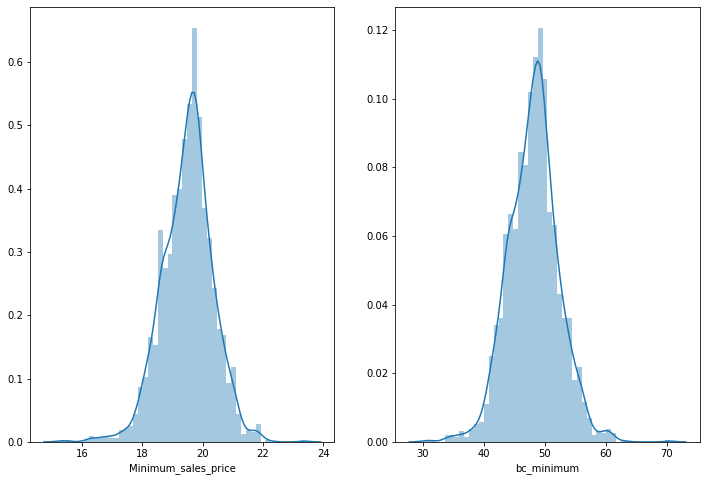

In [95]:
f, ax = plt.subplots(nrows=1, ncols=2,figsize=(12,8))
sns.distplot(np.log1p(train['Minimum_sales_price']),ax=ax[0])
sns.distplot(train['bc_minimum'],ax=ax[1])

In [12]:
train['log_min_price'] = np.log(train['Minimum_sales_price'])
test['log_min_price'] = np.log(test['Minimum_sales_price'])

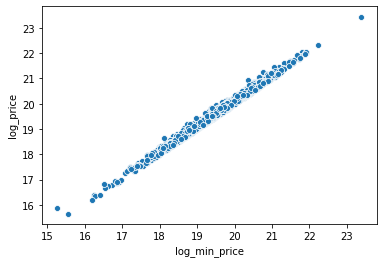

In [13]:
sns.scatterplot(x='log_min_price',y='log_price',data=train)

### Final_result
- train, test 모두 "낙찰" 밖에 없으므로 drop

In [10]:
print(len(train['Final_result']=='낙찰'))
(train['Final_result']=='낙찰').sum()

1933


1933

In [104]:
print(len(test['Final_result']=='낙찰'))
(test['Final_result']=='낙찰').sum()

829


829

### addr
- do: 시도
- si: 시군구
- dong: 읍면동
- li: 리
- san: 산번지 여부
- bunji1: 번지1
- bunji2: 번지2
- etc: 기타주소

In [129]:
train['addr_do'].unique()

array(['부산', '서울'], dtype=object)

In [130]:
test['addr_do'].unique()

array(['부산', '서울'], dtype=object)

In [131]:
############### 시 도  ###############
# 서울 0 부산 1
train['addr_do'] = (train['addr_do']=='부산').astype('int')
test['addr_do'] = (test['addr_do']=='부산').astype('int')

In [132]:
train['addr_do']

0       1
1       1
2       1
3       1
4       1
       ..
1928    0
1929    0
1930    0
1931    0
1932    0
Name: addr_do, Length: 1933, dtype: int32

In [136]:
train.addr_si.unique()

array(['해운대구', '사상구', '남구', '사하구', '영도구', '서구', '부산진구', '연제구', '수영구',
       '동래구', '동구', '중구', '강서구', '북구', '금정구', '기장군', '강남구', '은평구', '서초구',
       '영등포구', '양천구', '마포구', '금천구', '성동구', '노원구', '서대문구', '용산구', '구로구',
       '강북구', '관악구', '송파구', '도봉구', '광진구', '중랑구', '동대문구', '강동구', '성북구',
       '동작구', '종로구'], dtype=object)

In [137]:
train.addr_si.value_counts()

노원구     129
강남구     102
사하구      96
해운대구     89
부산진구     84
강서구      78
서초구      73
마포구      71
도봉구      68
양천구      68
송파구      60
사상구      58
구로구      57
남구       56
동대문구     53
북구       53
은평구      53
동래구      51
영등포구     47
성북구      45
관악구      43
강동구      39
중랑구      37
동작구      37
서대문구     37
수영구      33
연제구      31
중구       30
영도구      29
성동구      29
금정구      29
용산구      27
금천구      25
기장군      23
광진구      23
강북구      21
서구       17
종로구      17
동구       15
Name: addr_si, dtype: int64

In [203]:
seoul = train[train_orig['addr_do']=='서울']
busan = train[train_orig['addr_do']=='부산']

In [152]:
seoul

,Auction_key,Auction_class,Bid_class,Claim_price,Appraisal_company,Appraisal_date,Auction_count,Auction_miscarriage_count,Total_land_gross_area,Total_land_real_area,...,Close_result,point.y,point.x,Hammer_price,log_price,log_claim_price,log_land,log_building,bc_minimum,log_min_price
691,253,0,1,743392869,통일감정,2016-10-20 00:00:00,1,0,10728.0,48.07,...,배당,37.521426,127.040646,1049000000,20.771103,20.426735,3.872658,4.441710,53.482510,20.561923
692,832,0,1,137279809,준일감정,2016-09-23 00:00:00,2,1,1120.4,41.20,...,배당,37.604960,126.906565,291110000,19.489212,18.737532,3.718438,4.179298,47.020820,19.296149
693,385,0,1,2000000000,석원감정,2017-06-01 00:00:00,1,0,15552.6,30.51,...,배당,37.483586,127.017687,1261000000,20.955171,21.416413,3.418054,4.954065,55.581453,20.946409
694,1157,0,1,162880199,경문감정,2017-01-06 00:00:00,2,1,25890.3,40.37,...,배당,37.529884,126.908225,721110000,20.396302,18.908526,3.698087,4.683519,51.425472,20.173006
695,190,0,1,602404846,구수미감정,2016-04-20 00:00:00,2,1,1182.3,78.82,...,배당,37.490184,127.022173,865000000,20.578240,20.216440,4.367167,5.171279,53.513998,20.567781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1928,1567,1,1,280000000,삼창감정,2017-02-16 00:00:00,1,0,66419.3,40.55,...,배당,37.648810,127.048683,402500000,19.813206,19.450300,3.702536,4.441121,49.560954,19.809472
1929,1295,0,1,200000000,삼상감정,2015-02-21 00:00:00,2,1,20433.8,39.60,...,배당,37.663291,127.077063,430234600,19.879841,19.113828,3.678829,4.743279,49.062687,19.710464
1930,254,0,1,354805459,서초감정,2016-10-21 00:00:00,2,1,7460.8,19.03,...,배당,37.558319,126.981994,1118999990,20.835701,19.687080,2.946017,4.897691,54.505802,20.750881
1931,1486,1,1,80000000,한미감정,2016-06-17 00:00:00,2,1,16875.8,42.20,...,배당,37.647061,127.028002,403000000,19.814447,18.197537,3.742420,4.441945,48.517367,19.601180


In [158]:
from sklearn.preprocessing import LabelEncoder as LE
enc = LE()

In [155]:
seoul['addr_si'] = enc.fit_transform(seoul['addr_si'])

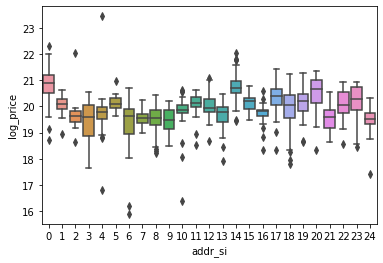

In [157]:
sns.boxplot(x='addr_si',y='log_price',data=seoul)

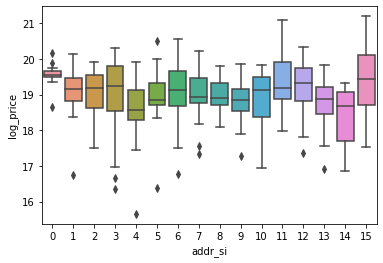

In [160]:
busan['addr_si'] = enc.fit_transform(busan['addr_si'])
sns.boxplot(x='addr_si',y='log_price',data=busan)

In [195]:
f = open('C:/kaggle_data/house_auction/si_pop_s.txt', 'r',encoding='utf8')
lines = f.readlines()
f.close()

In [196]:
lines[1].split('\t')
names=[]
pops=[]
for line in lines[2:]:
    line = line.split('\t')
    names.append(line[1])
    pops.append(int(line[2].replace(',','')))

In [197]:
s = pd.DataFrame({'name':names,'pop':pops})

In [198]:
s['ratio'] = s['pop']/sum(s['pop'])

In [200]:
s['ratio'].sum()

0.9999999999999999

In [216]:
seoul['addr_si']

691      강남구
692      은평구
693      서초구
694     영등포구
695      서초구
        ... 
1928     도봉구
1929     노원구
1930      중구
1931     도봉구
1932     강서구
Name: addr_si, Length: 1242, dtype: object

In [212]:
s

,name,pop,ratio,enc_name
0,종로구,75003,0.016977,22
1,중구,63686,0.014415,23
2,용산구,113093,0.025599,20
3,성동구,135870,0.030754,15
4,광진구,167427,0.037897,5
5,동대문구,167598,0.037936,10
6,중랑구,185920,0.042083,24
7,성북구,195396,0.044228,16
8,강북구,145896,0.033023,2
9,도봉구,139114,0.031488,9


In [281]:
train[train['addr_do']==0]

,Auction_key,Auction_class,Bid_class,Claim_price,Appraisal_company,Appraisal_date,Auction_count,Auction_miscarriage_count,Total_land_gross_area,Total_land_real_area,...,Close_result,point.y,point.x,Hammer_price,log_price,log_claim_price,log_land,log_building,bc_minimum,log_min_price
691,253,0,1,743392869,통일감정,2016-10-20 00:00:00,1,0,10728.0,48.07,...,배당,37.521426,127.040646,1049000000,20.771103,20.426735,3.872658,4.441710,53.482510,20.561923
692,832,0,1,137279809,준일감정,2016-09-23 00:00:00,2,1,1120.4,41.20,...,배당,37.604960,126.906565,291110000,19.489212,18.737532,3.718438,4.179298,47.020820,19.296149
693,385,0,1,2000000000,석원감정,2017-06-01 00:00:00,1,0,15552.6,30.51,...,배당,37.483586,127.017687,1261000000,20.955171,21.416413,3.418054,4.954065,55.581453,20.946409
694,1157,0,1,162880199,경문감정,2017-01-06 00:00:00,2,1,25890.3,40.37,...,배당,37.529884,126.908225,721110000,20.396302,18.908526,3.698087,4.683519,51.425472,20.173006
695,190,0,1,602404846,구수미감정,2016-04-20 00:00:00,2,1,1182.3,78.82,...,배당,37.490184,127.022173,865000000,20.578240,20.216440,4.367167,5.171279,53.513998,20.567781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1928,1567,1,1,280000000,삼창감정,2017-02-16 00:00:00,1,0,66419.3,40.55,...,배당,37.648810,127.048683,402500000,19.813206,19.450300,3.702536,4.441121,49.560954,19.809472
1929,1295,0,1,200000000,삼상감정,2015-02-21 00:00:00,2,1,20433.8,39.60,...,배당,37.663291,127.077063,430234600,19.879841,19.113828,3.678829,4.743279,49.062687,19.710464
1930,254,0,1,354805459,서초감정,2016-10-21 00:00:00,2,1,7460.8,19.03,...,배당,37.558319,126.981994,1118999990,20.835701,19.687080,2.946017,4.897691,54.505802,20.750881
1931,1486,1,1,80000000,한미감정,2016-06-17 00:00:00,2,1,16875.8,42.20,...,배당,37.647061,127.028002,403000000,19.814447,18.197537,3.742420,4.441945,48.517367,19.601180


In [11]:
b = pd.read_csv(os.path.join(d,'si_pop_b.csv'),encoding='cp949',header=1)
b = b.iloc[1:,[0,3]]
b['ratio'] = b['인구수  (명)']/sum(b['인구수  (명)'])
b = b.reset_index(drop=True)

FileNotFoundError: [Errno 2] No such file or directory: 'C:/kaggle_data/house_auction/si_pop_b.csv'

In [244]:
s_idx = list(s.iloc[:,0])
b_idx = list(b.iloc[:,0])

In [284]:
s

,name,pop,ratio,enc_name
0,종로구,75003,0.016977,22
1,중구,63686,0.014415,23
2,용산구,113093,0.025599,20
3,성동구,135870,0.030754,15
4,광진구,167427,0.037897,5
5,동대문구,167598,0.037936,10
6,중랑구,185920,0.042083,24
7,성북구,195396,0.044228,16
8,강북구,145896,0.033023,2
9,도봉구,139114,0.031488,9


In [263]:
b

,구·군별,인구수 (명),ratio
0,중구,43571,0.012656
1,서구,110027,0.031960
2,동구,91194,0.026490
3,영도구,115513,0.033554
4,부산진구,362213,0.105214
5,동래구,272403,0.079126
6,남구,273735,0.079513
7,북구,287203,0.083425
8,해운대구,407182,0.118276
9,사하구,317333,0.092177


In [289]:
for i in range(len(train)):
    if train.loc[i,'addr_do'] == 0: # 0이면 서울, s테이블 참조
        addr_si = train.loc[i,'addr_si']
        ratio = s.loc[s_idx.index(addr_si),'ratio']
        train.loc[i,'addr_ratio'] = ratio
        
    else:
        addr_si = train.loc[i,'addr_si']
        ratio = b.loc[b_idx.index(addr_si),'ratio']
        train.loc[i,'addr_ratio'] = ratio

In [290]:
train[['addr_si','addr_ratio']]

,addr_si,addr_ratio
0,해운대구,0.118276
1,해운대구,0.118276
2,사상구,0.063262
3,남구,0.079513
4,사하구,0.092177
...,...,...
1928,도봉구,0.031488
1929,노원구,0.049405
1930,중구,0.014415
1931,도봉구,0.031488


In [301]:
for i in range(len(test)):
    if test.loc[i,'addr_do'] == 0: # 0이면 서울, s테이블 참조
        addr_si = test.loc[i,'addr_si']
        ratio = s.loc[s_idx.index(addr_si),'ratio']
        test.loc[i,'addr_ratio'] = ratio
        
    else:
        addr_si = test.loc[i,'addr_si']
        ratio = b.loc[b_idx.index(addr_si),'ratio']
        test.loc[i,'addr_ratio'] = ratio

### Completion_date를 하려고 했는데 칼럼이 없었다

In [169]:
for i in train.columns:
    if 'date' in i:
        print(i)

Appraisal_date
First_auction_date
Final_auction_date
Preserve_regist_date
Close_date


In [307]:
my_cols = ['log_claim_price',
            'Auction_class',
            'Bid_class',
            'log_land',
            'log_building',
            'log_min_price',
            'addr_do',
            'addr_ratio']

In [308]:
train_df = train[my_cols]
test_df = test[my_cols]

In [309]:
y = train.pop('log_price')

In [310]:
display(train_df.head())
display(test_df.head())

,log_claim_price,Auction_class,Bid_class,log_land,log_building,log_min_price,addr_do,addr_ratio
0,21.292004,0,0,3.620333,5.202742,20.320996,1,0.118276
1,18.845601,0,1,2.931727,4.773900,20.570581,1,0.118276
2,16.242657,0,0,4.262680,3.910822,18.148347,1,0.063262
3,19.028170,0,1,3.495901,4.441592,19.256715,1,0.079513
4,17.641707,1,1,3.810655,4.442181,18.728165,1,0.092177


,log_claim_price,Auction_class,Bid_class,log_land,log_building,log_min_price,addr_do,addr_ratio
0,20.806687,1,0,2.90252,4.675442,18.422419,1,0.079126
1,20.806687,1,0,2.81241,4.585783,18.578693,1,0.079126
2,20.806687,1,0,2.90252,4.675442,18.442657,1,0.079126
3,20.806687,1,0,2.90252,4.675442,18.442657,1,0.079126
4,20.806687,1,0,2.90252,4.675442,18.442657,1,0.079126


In [314]:
import xgboost as xgb
xgb_reg = xgb.XGBRFRegressor()

In [315]:
xgb_reg.fit(train_df,y, eval_metric='rmse')

XGBRFRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bytree=1, gamma=0, gpu_id=-1, importance_type='gain',
               interaction_constraints='', max_delta_step=0, max_depth=6,
               min_child_weight=1, missing=nan, monotone_constraints='()',
               n_estimators=100, n_jobs=0, num_parallel_tree=100,
               objective='reg:squarederror', random_state=0, reg_alpha=0,
               scale_pos_weight=1, tree_method='exact', validate_parameters=1,
               verbosity=None)

In [316]:
pred = xgb_reg.predict(test_df)

In [322]:
pred.dtype

dtype('float32')

In [318]:
test

,Auction_key,Auction_class,Bid_class,Claim_price,Appraisal_company,Appraisal_date,Auction_count,Auction_miscarriage_count,Total_land_gross_area,Total_land_real_area,...,Close_result,point.y,point.x,Hammer_price,log_claim_price,log_land,log_building,bc_minimum,log_min_price,addr_ratio
0,1778,1,0,1087000000,대한감정,2012-06-11 00:00:00,7,6,532.0,18.22,...,배당,35.201112,129.088687,0,20.806687,2.902520,4.675442,94.341995,18.422419,0.079126
1,1779,1,0,1087000000,대한감정,2012-06-11 00:00:00,6,5,532.0,16.65,...,배당,35.201112,129.088687,0,20.806687,2.812410,4.585783,96.681307,18.578693,0.079126
2,1784,1,0,1087000000,대한감정,2012-06-11 00:00:00,7,6,532.0,18.22,...,배당,35.201112,129.088687,0,20.806687,2.902520,4.675442,94.641944,18.442657,0.079126
3,1786,1,0,1087000000,대한감정,2012-06-11 00:00:00,7,6,532.0,18.22,...,배당,35.201112,129.088687,0,20.806687,2.902520,4.675442,94.641944,18.442657,0.079126
4,1790,1,0,1087000000,대한감정,2012-06-11 00:00:00,7,6,532.0,18.22,...,배당,35.201112,129.088687,0,20.806687,2.902520,4.675442,94.641944,18.442657,0.079126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
824,1762,1,0,4249164200,강림감정,2017-06-12 00:00:00,2,1,3460.9,13.87,...,배당,37.605407,127.027309,0,22.169988,2.629728,4.441592,113.934615,19.632622,0.044228
825,1767,1,1,320000000,삼일감정,2017-06-27 00:00:00,2,1,13578.9,72.81,...,배당,37.663305,127.039551,0,19.583832,4.287853,5.015026,119.773025,19.955395,0.031488
826,1770,1,1,160000000,성북감정,2017-08-01 00:00:00,2,1,57491.8,34.03,...,배당,37.614529,127.091109,0,18.890684,3.527242,3.907412,107.738492,19.272540,0.042083
827,1772,0,1,230000000,생림감정,2017-09-28 00:00:00,1,0,27710.2,42.54,...,배당,37.620359,127.047071,0,19.253590,3.750445,4.440767,120.862770,20.013989,0.044228


In [336]:
ss = pd.read_csv(d+'Auction_submission.csv')

In [333]:
ss['Hammer_price'] = np.expm1(pred)
ss['Hammer_price'] = ss['Hammer_price'].astype('int64')

In [334]:
ss.to_csv('baseline.csv',index=False)

In [346]:
ss.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 829 entries, 0 to 828
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   Auction_key   829 non-null    int64
 1   Hammer_price  829 non-null    int64
dtypes: int64(2)
memory usage: 13.1 KB


In [345]:
pd.read_csv('C:\\kaggle_sj\\house_auction'+'\\baseline.csv').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 829 entries, 0 to 828
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   Auction_key   829 non-null    int64
 1   Hammer_price  829 non-null    int64
dtypes: int64(2)
memory usage: 13.1 KB


target값: log_price

claim_price -> log_claim_price (log1p)

auction_class 라벨인코딩

bid_class  라벨인코딩

Total_land_auction_area -> log_land

Total_building_auction_area -> log_building

Minimum_sales_price -> log_min_price

addr_do -> 라벨 인코딩

addr_si -> addr_ratio 로 전체 인구대비로 바꿨음